In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import entropy

from utils.simulation import *
from utils.mutual import (compute_mutual_information_from_trajectories, mutual_information_slowjumps, MC_underhood)
from utils.plotting import *
from utils.analytical import *

data_folder = 'data/'
lw = 2

/home/barzon/.local/lib/python3.8/site-packages/numba/core/errors.py:175: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
def get_default_params_system():
    ### Info system
    N = 2
    w = 2
    k = 1.1
    tau_ei = 1
    r = np.ones(N)
    
    return {'N': N, 'w': w, 'k': k, 'tau_ei': tau_ei, 'r': r}

# Figure 1 - Role of timescales

### Example of trajectory for slow timescale

In [3]:
### Info input
M = 3
tau_h = 100
wup = 1 / tau_h
wdown = 2 / tau_h
delta_h = 3
hs = np.arange(M) * delta_h
hs = np.stack([hs, np.zeros(M)])

W = create_transition_matrix_star_graph(M, wup, wdown)

p_stat = np.array([wdown] + [wup] * (M-1))
p_stat = p_stat / p_stat.sum()

### Info simulation
steps = int(5e6)
dt = 0.005

### Create info dictionary
info_system = create_info_system(**get_default_params_system())
info_input = create_info_input(W, hs)
info_simulation = create_info_simulation(steps,dt)

In [15]:
### Simulate state
inputs_slow, states_slow = simulate_coupled_system(info_system, info_input, info_simulation, seed=2)

### Store data
np.save(data_folder+'inputs_slow.npy', inputs_slow)
np.save(data_folder+'states_slow.npy', states_slow)

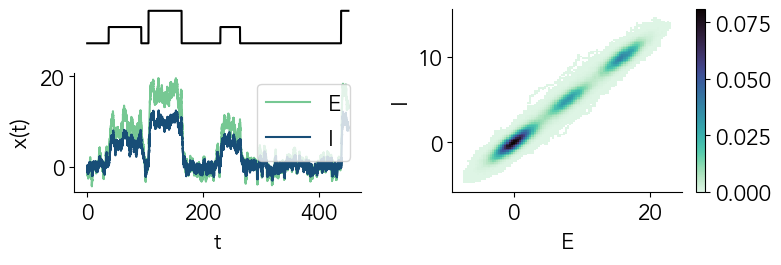

In [16]:
### Plot simulation
inputs_slow = np.load(data_folder+'inputs_slow.npy')
states_slow = np.load(data_folder+'states_slow.npy')

plot_simulation(states_slow, inputs_slow, hs[0], dt, fname='fig_1_example_slow', max_steps_to_plot=int(9e4))

### Example of trajectory for fast timescale

In [17]:
### Info input
M = 3
tau_h = 5
wup = 1 / tau_h
wdown = 2 / tau_h
delta_h = 3
hs = np.arange(M) * delta_h
hs = np.stack([hs, np.zeros(M)])

W = create_transition_matrix_star_graph(M, wup, wdown)

p_stat = np.array([wdown] + [wup] * (M-1))
p_stat = p_stat / p_stat.sum()

### Info simulation
steps = int(5e6)
dt = 0.005

### Create info dictionary
info_system = create_info_system(**get_default_params_system())
info_input = create_info_input(W, hs)
info_simulation = create_info_simulation(steps,dt)

In [18]:
### Simulate state
inputs_fast, states_fast = simulate_coupled_system(info_system, info_input, info_simulation, seed=2)

### Store data
np.save(data_folder+'inputs_fast.npy', inputs_fast)
np.save(data_folder+'states_fast.npy', states_fast)

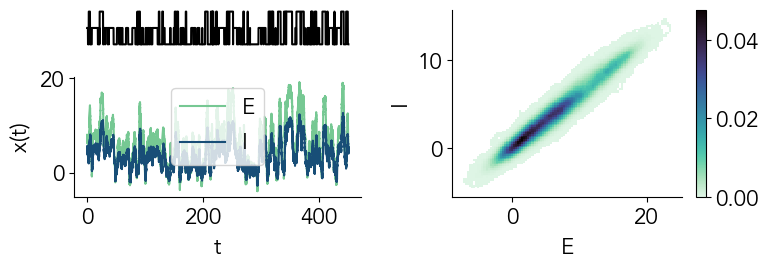

In [20]:
### Plot simulation
inputs_fast = np.load(data_folder+'inputs_fast.npy')
states_fast = np.load(data_folder+'states_fast.npy')

plot_simulation(states_fast, inputs_fast, hs[0], dt, fname='fig_1_example_fast', max_steps_to_plot=int(9e4))

### Compute MI by varying tau_jumps

In [7]:
### Info input
M = 3
tau_h = 100
wup = 1 / tau_h
wdown = 2 / tau_h
delta_h = 2
hs = np.arange(M) * delta_h
hs = np.stack([hs, np.zeros(M)])

W = create_transition_matrix_star_graph(M, wup, wdown)

p_stat = np.array([wdown] + [wup] * (M-1))
p_stat = p_stat / p_stat.sum()

### Info system - increase w
info_system['w'] = 40

In [8]:
### Simulation params
taus = np.logspace(-1,3,10)
bins = 100

### Info simulation
steps = int(1e7)
dt = 0.01

In [9]:
ress = np.zeros(taus.size)

for idx, tau in enumerate(taus):
    print(f'[*] tau={tau}')
    ### Info input
    wup = 1 / tau
    wdown = 2 / tau

    W = create_transition_matrix_star_graph(M, wup, wdown)
    
    ### Create info dictionaries
    info_input = create_info_input(W, hs)
    info_simulation = create_info_simulation(steps,dt)
    
    ### Simulate state
    inputs, states = simulate_coupled_system(info_system, info_input, info_simulation)
    
    ### Compute MI
    ress[idx] = compute_mutual_information_from_trajectories(states, inputs, bins)
    
### Store mutual
np.save(data_folder+'mutual_different_timescales.npy', ress)

[*] tau=0.1
[*] tau=0.2782559402207124
[*] tau=0.774263682681127
[*] tau=2.1544346900318834
[*] tau=5.994842503189409
[*] tau=16.68100537200059
[*] tau=46.41588833612777
[*] tau=129.15496650148827
[*] tau=359.38136638046257
[*] tau=1000.0


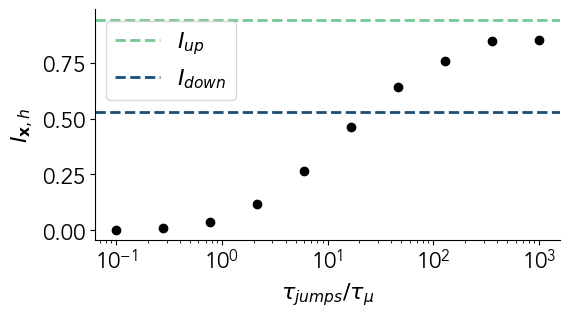

In [10]:
### Load mutual
ress = np.load(data_folder+'mutual_different_timescales.npy')

### Compute bounds
upper_bound = theo_ub(info_system['w'], info_system['k'], p_stat, info_input['hs'])
lower_bound = theo_lb(info_system['w'], info_system['k'], p_stat, info_input['hs'])

plt.figure(figsize=(6,3))
plt.plot(taus / info_system['tau_ei'], ress, 'o', c='k')
#plt.axhline(entropy(p_stat), c='gray', ls='--', lw=lw, label=r'$H_{jumps}$')
plt.axhline(upper_bound, c=colors[0], ls='--', lw=lw, label=r'$I_{up}$')
plt.axhline(lower_bound, c=colors[1], ls='--', lw=lw, label=r'$I_{down}$')
plt.xscale('log')
plt.xlabel(r'$\tau_{jumps} / \tau_{\mu}$')
plt.ylabel(r'$I_{\mathbf{x},h}$')
plt.legend()
sns.despine()
plt.show()

# Figure 2 - Edge of stability

In [4]:
### Info input
M = 3
tau_h = 100
wup = 1 / tau_h
wdown = 2 / tau_h
delta_h = 0.5
hs = np.arange(M) * delta_h
hs = np.stack([hs, np.zeros(M)])

W = create_transition_matrix_star_graph(M, wup, wdown)

p_stat = np.array([wdown] + [wup] * (M-1))
p_stat = p_stat / p_stat.sum()

In [63]:
### Compute bounds

#kmin, kmax = 0.1, 2.
#wmin, wmax = 0.5, 100

kmin, kmax = 0., 1.5
wmin, wmax = 0.01, 10

nk, nw = int(5e2), int(5e2)

ks, ws = np.linspace(kmin, kmax, nw), np.linspace(wmin, wmax, nw)

Ks, Ws = np.meshgrid(ks, ws)

unstable = np.where(1 + Ws*(Ks-1)<=0)

Z = theo_W_factor(Ws, Ks)
Z[unstable] = np.nan

lbs = np.zeros(Ks.shape)
ubs = np.zeros(Ks.shape)

for (idx_x, idx_y) in np.ndindex(Ks.shape):
    if np.isnan(Z[idx_x, idx_y]):
        continue
    w, k = Ws[idx_x, idx_y], Ks[idx_x, idx_y]
    lbs[idx_x, idx_y] = theo_bound(w, k, p_stat, hs, 'lb')
    ubs[idx_x, idx_y] = theo_bound(w, k, p_stat, hs, 'ub')
    
lbs[unstable] = np.nan
ubs[unstable] = np.nan

print(entropy(p_stat), np.nanmax(ubs), np.nanmax(lbs), np.nanmax(Z))

1.0397207708399179 1.0397207708399179 1.0397207708399179 92922.67644879733


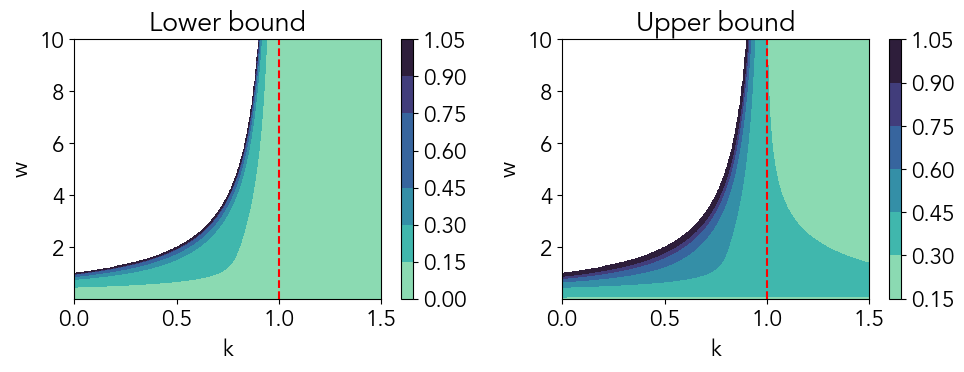

In [35]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.contourf(Ks, Ws, lbs, cmap=my_cmap) #, vmin=0, vmax=entropy(p_stat)
plt.colorbar()
plt.xlabel('k')
plt.ylabel('w')
plt.axvline(1, c='r', ls='--')
plt.title('Lower bound')

plt.subplot(1,2,2)
plt.contourf(Ks, Ws, ubs, cmap=my_cmap) #, vmin=0, vmax=entropy(p_stat)
plt.colorbar()
plt.xlabel('k')
plt.ylabel('w')
plt.axvline(1, c='r', ls='--')
plt.title('Upper bound')

plt.tight_layout()
plt.show()

In [5]:
kmin, kmax = 0., 5
wmin, wmax = 0.01, 10

nk, nw = int(5e2), int(5e2)

ks, ws = np.linspace(kmin, kmax, nw), np.linspace(wmin, wmax, nw)

Ks, Ws = np.meshgrid(ks, ws)

unstable = np.where(1 + Ws*(Ks-1)<=0)

Z = theo_W_factor(Ws, Ks)
Z[unstable] = np.nan

lbs = np.zeros(Ks.shape)
ubs = np.zeros(Ks.shape)

for (idx_x, idx_y) in np.ndindex(Ks.shape):
    if np.isnan(Z[idx_x, idx_y]):
        continue
    w, k = Ws[idx_x, idx_y], Ks[idx_x, idx_y]
    lbs[idx_x, idx_y] = theo_bound(w, k, p_stat, hs, 'lb')
    ubs[idx_x, idx_y] = theo_bound(w, k, p_stat, hs, 'ub')
    
lbs[unstable] = np.nan
ubs[unstable] = np.nan

print(entropy(p_stat), np.nanmax(ubs), np.nanmax(lbs), np.nanmax(Z))

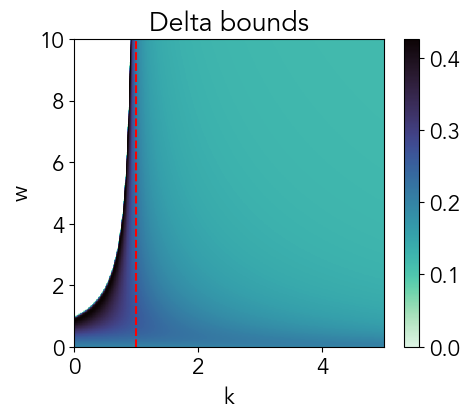

In [7]:
plt.figure(figsize=(5,4))

plt.pcolormesh(Ks, Ws, ubs-lbs, cmap=my_cmap_continuous) #, vmin=0, vmax=entropy(p_stat)
plt.colorbar()
plt.xlabel('k')
plt.ylabel('w')
plt.axvline(1, c='r', ls='--')
plt.title('Delta bounds')

plt.show()

### Plot mutual from Pjoint with importance sampling

In [9]:
### Info input
M = 3
tau_h = 100
wup = 1 / tau_h
wdown = 2 / tau_h
delta_h = 3
hs = np.arange(M) * delta_h
hs = np.stack([hs, np.zeros(M)])

W = create_transition_matrix_star_graph(M, wup, wdown)

p_stat = np.array([wdown] + [wup] * (M-1))
p_stat = p_stat / p_stat.sum()

In [10]:
### Define grid params
kmin, kmax = 0., 5
wmin, wmax = 0.01, 10

nk, nw = int(2e2), int(2e2)

k_list, w_list = np.linspace(kmin, kmax, nw), np.linspace(wmin, wmax, nw)

print(w_list.size * k_list.size)

40000


In [11]:
### Compute mutual
#mutuals = mutual_information_slowjumps(w_list, k_list, hs, p_stat, nsamples = int(1e5))
#np.save(data_folder+'mutual_importance_sampling.npy', mutuals)

In [12]:
### Load results
mutuals = np.load(data_folder+'mutual_importance_sampling.npy')

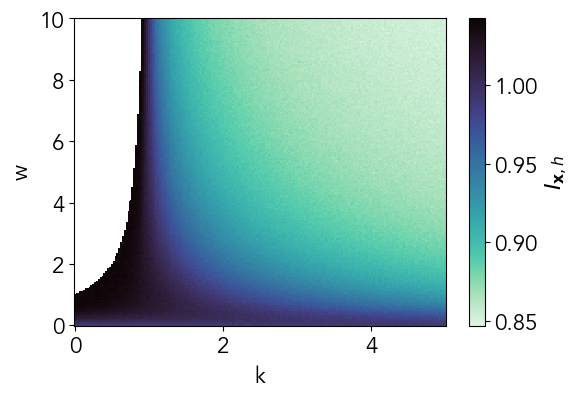

In [13]:
Ws, Ks = np.meshgrid(w_list, k_list)

plt.figure(figsize=(6,4))
plt.pcolor(Ks, Ws, mutuals.T, cmap=my_cmap_continuous)
plt.xlabel('k')
plt.ylabel('w')
cbar = plt.colorbar()
cbar.ax.set_ylabel(r'$I_{\mathbf{x},h}$')
plt.show()

In [14]:
### Compute bounds
idx_w = 40
print('w:', w_list[idx_w])

unstable = np.where((k_list <= 1 - 1/w_list[idx_w]))[0]
print(unstable)

bounds_up = [theo_ub(w_list[idx_w], k, p_stat, info_input['hs']) for k in k_list]
bounds_down = [theo_lb(w_list[idx_w], k, p_stat, info_input['hs']) for k in k_list]

bounds_up = np.array(bounds_up)
bounds_down = np.array(bounds_down)

bounds_up[unstable] = np.nan
bounds_down[unstable] = np.nan

w: 2.018040201005025
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


/home/barzon/Mutual_Information/utils/analytical.py:81: RuntimeWarning: overflow encountered in exp
  tmp += pi[idx_j] * np.exp( -kl(w, k, hs[:,idx_i],hs[:,idx_j]) )
/home/barzon/Mutual_Information/utils/analytical.py:70: RuntimeWarning: overflow encountered in exp
  tmp += pi[idx_j] * np.exp( -ch(w, k, hs[:,idx_i],hs[:,idx_j]) )


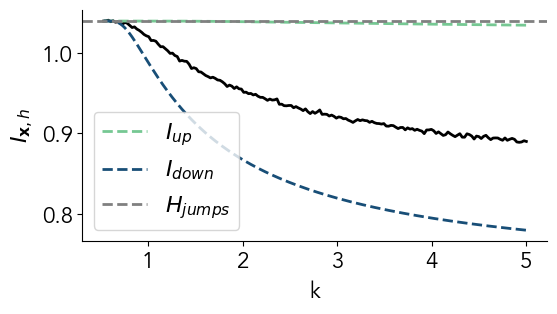

In [15]:
plt.figure(figsize=(6,3))

plt.plot(k_list, mutuals[idx_w], c='k', lw=lw)
plt.plot(k_list, bounds_up, c=colors[0], ls='--', lw=lw, label=r'$I_{up}$')
plt.plot(k_list, bounds_down, c=colors[1], ls='--', lw=lw, label=r'$I_{down}$')

plt.axhline(entropy(p_stat), c='gray', ls='--', lw=lw, label=r'$H_{jumps}$')

plt.legend()
sns.despine()
plt.xlabel('k')
plt.ylabel(r'$I_{\mathbf{x},h}$')
plt.show()

# Figure 3 - Time dependent